In [10]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
file = "dataset_file/file.txt"

splitted_line = []

with open(file) as f:
    for line in f.readlines():
        # print(line)
        if  int(line[0]) in [1,2,3]:
            splitted_line.append([line[0], line[2:]])


print(splitted_line.pop(0))



['1', 'champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter \n']


In [12]:
dataset = pd.DataFrame(list(splitted_line), columns=["labels", "text"])

In [13]:
dataset.head()

,labels,text
0,2,computer terminal systems cpml completes sale ...
1,1,cobanco inc cbco year net shr cts vs dlrs net ...
2,1,am international inc am nd qtr jan oper shr lo...
3,1,brown forman inc bfd th qtr net shr one dlr vs...
4,1,dean foods df sees strong th qtr earnings dean...


In [14]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [15]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Example
print(X[0])
print(sequences[0])

computer terminal systems cpml completes sale computer terminal systems inc said it has completed the sale of shares of its common stock and warrants to acquire an additional one mln shares to sedio n v of lugano switzerland for dlrs the company said the warrants are exercisable for five years at a purchase price of dlrs per share computer terminal said sedio also has the right to buy additional shares and increase its total holdings up to pct of the computer terminal s outstanding common stock under certain circumstances involving change of control at the company the company said if the conditions occur the warrants would be exercisable at a price equal to pct of its common stock s market price at the time not to exceed dlrs per share computer terminal also said it sold the technolgy rights to its dot matrix impact technology including any future improvements to woodco inc of houston tex for dlrs but it said it would continue to be the exclusive worldwide licensee of the technology fo

In [16]:
X_encoded = pad_sequences(sequences, maxlen=80, padding='post')

print(X_encoded[0])

[  340  2206    61     9    12   245     1 10382   379     3    18  1299
  6337   708   425   303   193   349  2299     3  7756    22     2  1227
  7757    13    10    67    12     9    12    47   359     3    34     1
  2848  1005  3277     2     1   425    13  7756     1    20     9     1
  1253    78   258     2    18  1300   224     8    47   709    99   159
   644   272     8  1955   610  1444   340  2206   611   340  2849  5405
  2525 10383     8  3809  4712     8  4713    16]


In [17]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [18]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=80))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [19]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/text_classification_model{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/text_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [20]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
27/27 [==============================] - 37s 1s/step - loss: 0.9342 - accuracy: 0.5950 - val_loss: 0.7374 - val_accuracy: 0.5936
Epoch 2/100
27/27 [==============================] - 33s 1s/step - loss: 0.6494 - accuracy: 0.7086 - val_loss: 0.4868 - val_accuracy: 0.8258
Epoch 3/100
27/27 [==============================] - 36s 1s/step - loss: 0.2833 - accuracy: 0.9096 - val_loss: 0.2637 - val_accuracy: 0.9182
Epoch 4/100
27/27 [==============================] - 34s 1s/step - loss: 0.1548 - accuracy: 0.9579 - val_loss: 0.2151 - val_accuracy: 0.9313
Epoch 5/100
27/27 [==============================] - 33s 1s/step - loss: 0.0739 - accuracy: 0.9825 - val_loss: 0.3019 - val_accuracy: 0.9265
Epoch 6/100
27/27 [==============================] - 39s 1s/step - loss: 0.0843 - accuracy: 0.9819 - val_loss: 0.4076 - val_accuracy: 0.8957
Epoch 7/100
27/27 [==============================] - 38s 1s/step - loss: 0.0782 - accuracy: 0.9828 - val_loss: 0.2572 - val_accuracy: 0.9408
Epoch 8/100
2

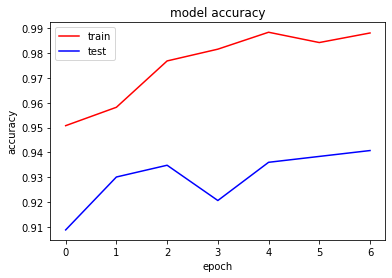

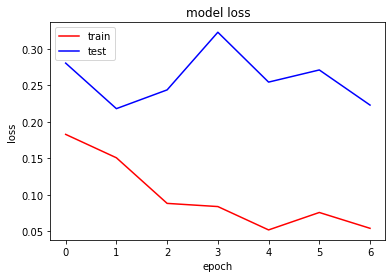

In [ ]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
rounded_labels=np.argmax(y_test, axis=1)


In [ ]:
# Validate model on training set
y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           1       0.97      0.96      0.97       284
           2       0.92      0.95      0.93       160
           3       0.95      0.80      0.87        25

    accuracy                           0.95       469
   macro avg       0.95      0.90      0.92       469
weighted avg       0.95      0.95      0.95       469

[[274   9   1]
 [  8 152   0]
 [  0   5  20]]
95.0959488272921


In [ ]:
labels = ["business", "entertainment", "politics", "sport", "tech"]
targets = [0,1,2,3,4]
dataset = []
for root, dirs, files in os.walk("./archive/bbc", topdown=False):
    class_type = root.split("\")
    for file in files: 
        print(root)
    # if root is ("archive/bbc"):
    #     with open(files) as f: 

# for  

./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/bbc\business
./archive/b